In [1]:
from clearsky.main import StatisticalClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}

In [2]:
from os.path import expanduser
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')

In [3]:
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')

In [4]:
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADHC1036570')
        and meas_name = 'ac_power'
        and ts < '2018-2-2';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)

In [5]:
df = make_time_series(df, return_keys=False).fillna(0)

In [6]:
df.head()

,ac_power_01
2015-04-09 09:25:00,4.6110
2015-04-09 09:30:00,4.6283
2015-04-09 09:35:00,4.8049
2015-04-09 09:40:00,4.9457
2015-04-09 09:45:00,5.1185


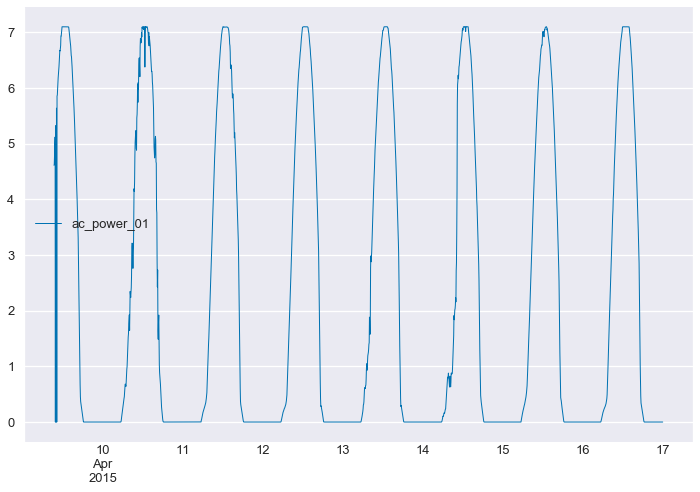

In [7]:
df.loc[:'4/16/15'].plot(**PLOT_ARGS)

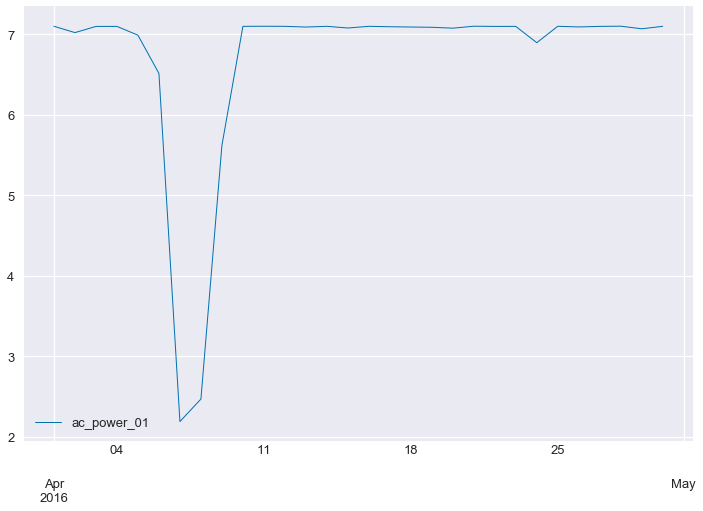

In [8]:
df.resample('D').max()['4/1/16':'4/30/16'].plot(**PLOT_ARGS)

In [9]:
df.loc[:'1/31/18'].tail()

,ac_power_01
2018-01-31 23:35:00,0.0
2018-01-31 23:40:00,0.0
2018-01-31 23:45:00,0.0
2018-01-31 23:50:00,0.0
2018-01-31 23:55:00,0.0


In [10]:
scs = StatisticalClearSky(df.loc['4/10/15':'1/31/18'])

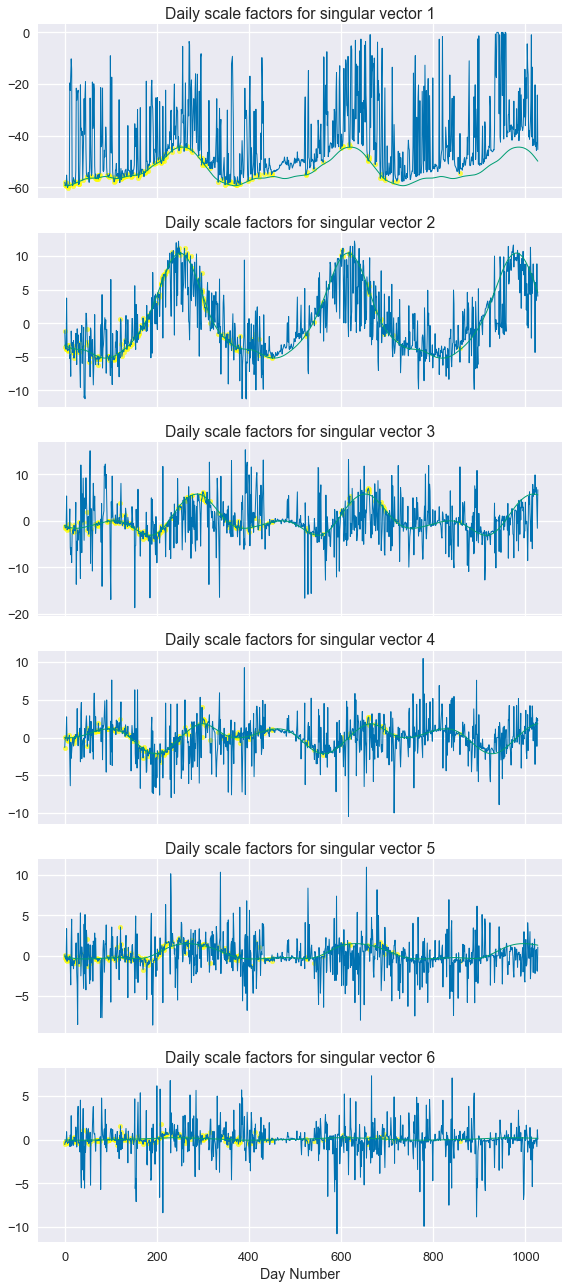

In [11]:
_ = scs.make_clearsky_model(n=6, plot=True)

In [13]:
scs.cleardays

array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  17,  18,  20,
        21,  22,  23,  30,  31,  32,  39,  48,  49,  50,  52,  58,  66,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  92,  93,  94,  95,
        96,  97, 105, 106, 107, 108, 109, 113, 116, 117, 121, 123, 124,
       128, 129, 130, 134, 135, 136, 142, 143, 145, 148, 156, 160, 161,
       162, 165, 166, 170, 171, 173, 174, 175, 176, 180, 181, 183, 193,
       194, 199, 203, 204, 205, 208, 209, 210, 211, 212, 214, 215, 216,
       217, 218, 220, 221, 232, 233, 246, 248, 249, 250, 260, 263, 265,
       266, 273, 277, 291, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       307, 315, 333, 342, 343, 348, 349, 354, 356, 357, 358, 360, 368,
       371, 372, 373, 374, 376, 377, 378, 379, 381, 398, 399, 407, 413,
       421, 422, 433, 441, 449, 451, 523, 524, 525, 541, 561, 599, 602,
       603, 617, 618, 619, 657, 658, 659, 660, 661, 674, 685, 686, 691,
       692, 696, 713, 721, 857])

In [25]:
ks = np.arange(5, 101, 5)
errors = np.empty_like(ks, dtype=float)
max_count = len(errors) - 1
bar_width = 40
for ind, k in enumerate(ks):
    scs.make_clearsky_model(n=k, plot=False)
    measured = scs.data[:, scs.cleardays]
    estimated = scs.estimate_clearsky(scs.cleardays % 365)
    rmse = np.linalg.norm(measured - estimated)
    errors[ind] = rmse
    b = bar_width * ind / max_count
    l = bar_width - b
    print '\r' + u"\u2588" * b + '-' * l,

████████████████████████████████████████                   


Text(0.5,0,u'Matrix rank')

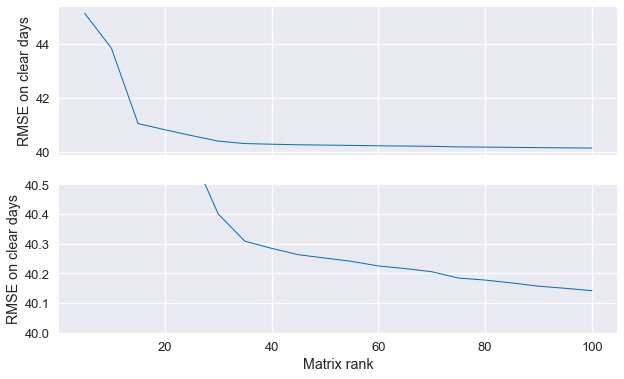

In [44]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
axes[0].plot(ks, errors, linewidth=1)
axes[0].set_ylabel('RMSE on clear days')
axes[1].plot(ks, errors, linewidth=1)
axes[1].set_ylabel('RMSE on clear days')
axes[1].set_ylim(40, 40.5)
axes[1].set_xlabel('Matrix rank')

In [27]:
errors

array([45.13795375, 43.84755988, 41.05048104, 40.82172211, 40.60462103,
       40.40078523, 40.3085048 , 40.28454134, 40.2630726 , 40.25179394,
       40.24058639, 40.2251121 , 40.21643687, 40.2057124 , 40.18431868,
       40.17750124, 40.16772004, 40.15687216, 40.14975091, 40.14176067])

Text(0.5,0,u'5-minute intervals')

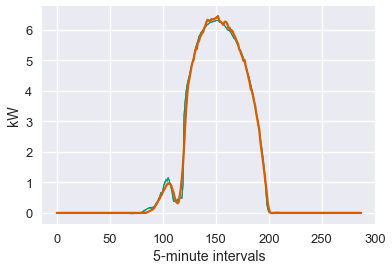

In [30]:
DAY = 250
scs.reconstruct_day(DAY, n=scs.DP_clearsky.shape[0])
estimates = scs.estimate_clearsky(np.s_[DAY%365:(DAY+1)%365])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i])
plt.ylabel('kW')
plt.xlabel('5-minute intervals')

Text(0.5,0,u'5-minute intervals')

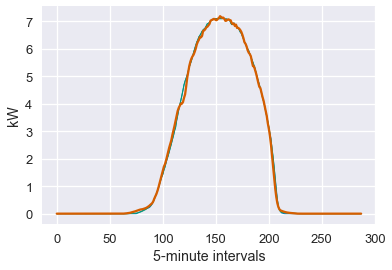

In [39]:
DAY = scs.cleardays[170]
scs.reconstruct_day(DAY, n=scs.DP_clearsky.shape[0])
estimates = scs.estimate_clearsky(np.s_[DAY%365:(DAY+1)%365])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i])
plt.ylabel('kW')
plt.xlabel('5-minute intervals')